In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv
/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv


# Github connection 

In [2]:
!pip install PyGithub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 6.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 25.9 MB/s eta 0:00:00


In [3]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/LorenzoBozzoni/RecSys_Challenge_Polimi_2024.git

Cloning into 'RecSys_Challenge_Polimi_2024'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 192 (delta 44), reused 176 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (192/192), 7.39 MiB | 15.44 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [4]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'RecSys_Challenge_Polimi_2024':
        repo = r
        print('Repository found')

Repository found


## Commit and push some specific file

In [5]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
        print('Commit and push completed successfully')
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())
        print(f'Exception {Exception} while trying to committing')

In [6]:
%cd /kaggle/working/RecSys_Challenge_Polimi_2024

/kaggle/working/RecSys_Challenge_Polimi_2024


In [7]:
#upload_file('/kaggle/working/RecSys_Challenge_Polimi_2024/recsys-challenge-2024.ipynb', './recsys-challenge-2024.ipynb', 'adding github connection from kaggle')

# Data exploration 
## URM
The URM contains a user for each row and an item for each column

In [8]:
URM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv")
URM_all_dataframe.head(10)

,user_id,item_id,data
0,0,0,1.0
1,0,2,1.0
2,0,120,1.0
3,0,128,1.0
4,0,211,1.0
5,0,232,1.0
6,0,282,1.0
7,0,453,1.0
8,0,458,1.0
9,0,491,1.0


In [9]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

The number of interactions is 1764607


In [10]:
userID_unique = URM_all_dataframe["user_id"].unique()
itemID_unique = URM_all_dataframe["item_id"].unique()
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))

Number of items	 38121, Number of users	 35736
Max ID items	 38120, Max Id users	 35735



In [11]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["user_id"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["item_id"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [12]:
original_item_ID = 292
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))
URM_all_dataframe.head(n=10)

New index for item 292 is 17024


,user_id,item_id,data
0,0,0,1.0
1,0,2,1.0
2,0,120,1.0
3,0,128,1.0
4,0,211,1.0
5,0,232,1.0
6,0,282,1.0
7,0,453,1.0
8,0,458,1.0
9,0,491,1.0


In [13]:
URM_all_dataframe["user_id"] = URM_all_dataframe["user_id"].map(user_original_ID_to_index)
URM_all_dataframe["item_id"] = URM_all_dataframe["item_id"].map(item_original_ID_to_index)

In [14]:
URM_all_dataframe.head(n=10)

,user_id,item_id,data
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
5,0,5,1.0
6,0,6,1.0
7,0,7,1.0
8,0,8,1.0
9,0,9,1.0


In [15]:
userID_unique = URM_all_dataframe["user_id"].unique()
itemID_unique = URM_all_dataframe["item_id"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))


Number of items	 38121, Number of users	 35736
Max ID items	 38120, Max Id users	 35735

Average interactions per user 49.38
Average interactions per item 46.29

Sparsity 99.87 %


In [16]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["data"].values, 
                          (URM_all_dataframe["user_id"].values, URM_all_dataframe["item_id"].values)))

URM_all

<COOrdinate sparse matrix of dtype 'float64'
	with 1764607 stored elements and shape (35736, 38121)>

In [17]:
URM_all.tocsr()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1764607 stored elements and shape (35736, 38121)>

In [18]:
item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity = np.sort(item_popularity)
item_popularity

array([  12,   13,   13, ..., 1254, 1310, 1470], dtype=int32)

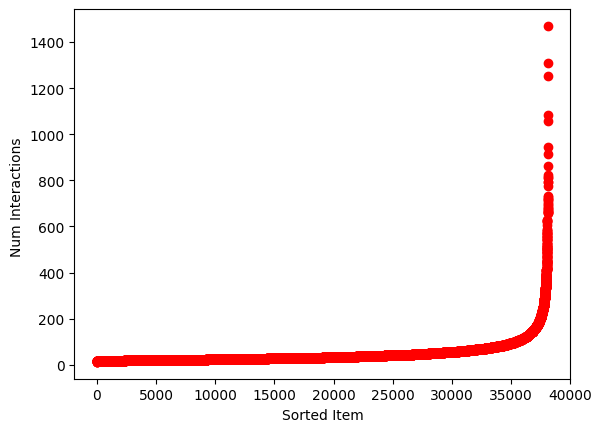

In [19]:
plt.plot(item_popularity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted Item')
plt.show()

In [20]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 46.29
Average per-item interactions for the top 10% popular items 153.63
Average per-item interactions for the least 10% popular items 17.95
Average per-item interactions for the median 10% popular items 31.50


In [21]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


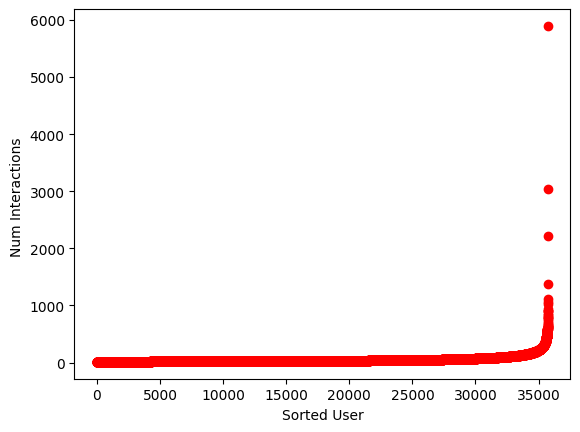

In [22]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


plt.plot(user_activity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted User')
plt.show()

## ICM
The ICM has one item for each row and one feature for each column

In [23]:
ICM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv")
ICM_all_dataframe.head(10)

,item_id,feature_id,data
0,2519,0,1.0
1,2642,0,1.0
2,3316,0,1.0
3,3400,0,1.0
4,3472,0,1.0
5,4361,0,1.0
6,4661,0,1.0
7,8697,0,1.0
8,9692,0,1.0
9,9693,0,1.0


In [24]:
featureID_unique = ICM_all_dataframe["feature_id"].unique()
itemID_unique_ICM = ICM_all_dataframe["item_id"].unique()

In [25]:
n_features = len(featureID_unique)
n_items_ICM = len(itemID_unique_ICM)
n_interactions_ICM = len(ICM_all_dataframe)

print ("Number of items\t {}, Number of features\t {}".format(n_items_ICM, n_features))
print ("Max ID items\t {}, Max Id features\t {}\n".format(max(itemID_unique_ICM), max(featureID_unique)))

Number of items	 38121, Number of features	 94331
Max ID items	 38120, Max Id features	 94330



In [26]:
mapped_id, original_id = pd.factorize(ICM_all_dataframe["feature_id"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(ICM_all_dataframe["item_id"].unique())
item_original_ID_to_index_ICM = pd.Series(mapped_id, index=original_id)

In [27]:
ICM_all_dataframe["feature_id"] = ICM_all_dataframe["feature_id"].map(feature_original_ID_to_index)
ICM_all_dataframe["item_id"] = ICM_all_dataframe["item_id"].map(item_original_ID_to_index_ICM)

In [28]:
ICM_all_dataframe.head(n=10)

,item_id,feature_id,data
0,0,0,1.0
1,1,0,1.0
2,2,0,1.0
3,3,0,1.0
4,4,0,1.0
5,5,0,1.0
6,6,0,1.0
7,7,0,1.0
8,8,0,1.0
9,9,0,1.0


In [29]:
featureID_unique = ICM_all_dataframe["feature_id"].unique()
itemID_unique_ICM = ICM_all_dataframe["item_id"].unique()

n_features = len(featureID_unique)
n_items_ICM = len(itemID_unique_ICM)
n_interactions_ICM = len(ICM_all_dataframe)

print ("Number of items\t {}, Number of features\t {}".format(n_items_ICM, n_features))
print ("Max ID items\t {}, Max Id features\t {}\n".format(max(itemID_unique_ICM), max(featureID_unique)))
print ("Average interactions per feature {:.2f}".format(n_interactions_ICM/n_features))
print ("Average interactions per item {:.2f}\n".format(n_interactions_ICM/n_items_ICM))

print ("Sparsity {:.2f} %".format((1-float(n_interactions_ICM)/(n_items_ICM*n_features))*100))


Number of items	 38121, Number of features	 94331
Max ID items	 38120, Max Id features	 94330

Average interactions per feature 31.17
Average interactions per item 77.12

Sparsity 99.92 %


In [30]:
ICM_all = sps.coo_matrix((ICM_all_dataframe["data"].values, (ICM_all_dataframe["item_id"].values,ICM_all_dataframe["feature_id"].values)))


ICM_all

<COOrdinate sparse matrix of dtype 'float64'
	with 2940040 stored elements and shape (38121, 94331)>

In [31]:
ICM_all.tocsr()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2940040 stored elements and shape (38121, 94331)>

In [32]:
item_popularity_ICM = np.ediff1d(ICM_all.tocsr().indptr)       # tocsc(), when rows and columns inverted
item_popularity_ICM = np.sort(item_popularity_ICM)
item_popularity_ICM 

array([   1,    1,    1, ..., 1084, 1199, 2013], dtype=int32)

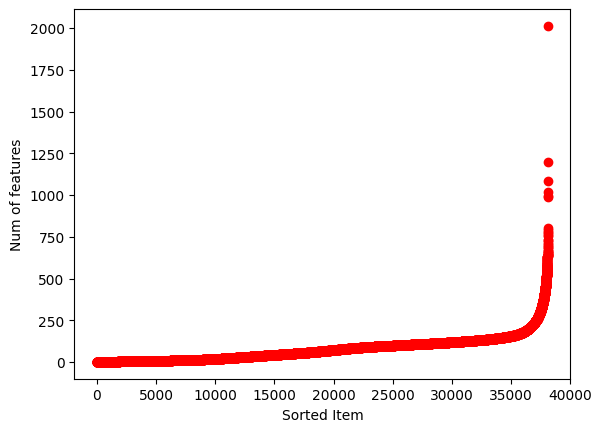

In [33]:
plt.plot(item_popularity_ICM, 'ro')
plt.ylabel('Num of features')
plt.xlabel('Sorted Item')
plt.show()

In [34]:
ten_percent = int(n_items_ICM/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity_ICM.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity_ICM[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity_ICM[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity_ICM[int(n_items_ICM*0.45):int(n_items_ICM*0.55)].mean()))

Average per-item interactions over the whole dataset 77.12
Average per-item interactions for the top 10% popular items 228.64
Average per-item interactions for the least 10% popular items 3.77
Average per-item interactions for the median 10% popular items 65.90


# Creating a validation set for testing our recommendation models

In [35]:
%cd /kaggle/working/RecSys_Challenge_Polimi_2024

/kaggle/working/RecSys_Challenge_Polimi_2024


In [36]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout

In [37]:
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 141 ( 0.4%) Users that have less than 1 test interactions


# 1. CFItemKNN recommender
## Taken from practice 05 file

In [38]:
def matrix_similarity(urm: sp.csc_matrix, shrink: int):
    item_weights = np.sqrt(
        np.sum(urm.power(2), axis=0)
    ).A
    
    numerator = urm.T.dot(urm)
    denominator = item_weights.T.dot(item_weights) + shrink + 1e-6
    weights = numerator / denominator
    weights = weights.todense()
    np.fill_diagonal(weights, 0.0)
    
    return weights

In [39]:
urm_csc = URM_train.tocsc()
shrink = 5
slice_size = 100

In [40]:
%%time
matrix_weights = matrix_similarity(urm_csc[:slice_size,:slice_size], shrink)
matrix_weights

CPU times: user 2.67 ms, sys: 1.11 ms, total: 3.78 ms
Wall time: 3.94 ms


matrix([[0.        , 0.13378038, 0.13378038, ..., 0.09307032, 0.09307032,
         0.15239211],
        [0.13378038, 0.        , 0.12499998, ..., 0.14854312, 0.14854312,
         0.13423736],
        [0.13378038, 0.12499998, 0.        , ..., 0.14854312, 0.14854312,
         0.13423736],
        ...,
        [0.09307032, 0.14854312, 0.14854312, ..., 0.        , 0.16666664,
         0.15590373],
        [0.09307032, 0.14854312, 0.14854312, ..., 0.16666664, 0.        ,
         0.15590373],
        [0.15239211, 0.13423736, 0.13423736, ..., 0.15590373, 0.15590373,
         0.        ]])

In [41]:
from typing import Tuple, Callable, Dict, Optional, List

In [42]:
class CFItemKNN(object):
    def __init__(self, shrink: int):
        self.shrink = shrink
        self.weights = None
    
    
    def fit(self, urm_train: sp.csc_matrix, similarity_function):
        if not sp.isspmatrix_csc(urm_train):
            raise TypeError(f"We expected a CSC matrix, we got {type(urm_train)}")
        
        self.weights = similarity_function(urm_train, self.shrink)
        
    def recommend(self, user_id: int, urm_train: sp.csr_matrix, at: Optional[int] = None, remove_seen: bool = True):
        user_profile = urm_train[user_id]
        
        ranking = user_profile.dot(self.weights).A.flatten()
        
        if remove_seen:
            user_profile_start = urm_train.indptr[user_id]
            user_profile_end = urm_train.indptr[user_id+1]
            
            seen_items = urm_train.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [43]:
itemknn_recommender = CFItemKNN(shrink=50)
itemknn_recommender

In [44]:
%%time

itemknn_recommender.fit(URM_train.tocsc(), matrix_similarity)

CPU times: user 20.1 s, sys: 20.2 s, total: 40.3 s
Wall time: 36.5 s


In [45]:
def recall(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant) / relevant_items.shape[0]
    
    return recall_score
    
    
def precision(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant) / recommendations.shape[0]

    return precision_score

def mean_average_precision(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    precision_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    map_score = np.sum(precision_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score
    

In [46]:
def evaluator(recommender: object, urm_train: sp.csr_matrix, urm_test: sp.csr_matrix):
    recommendation_length = 10
    accum_precision = 0
    accum_recall = 0
    accum_map = 0
    
    num_users = urm_train.shape[0]
    
    num_users_evaluated = 0
    num_users_skipped = 0
    for user_id in range(num_users):
        user_profile_start = urm_test.indptr[user_id]
        user_profile_end = urm_test.indptr[user_id+1]
        
        relevant_items = urm_test.indices[user_profile_start:user_profile_end]
        
        if relevant_items.size == 0:
            num_users_skipped += 1
            continue
            
        recommendations = recommender.recommend(user_id=user_id, 
                                               at=recommendation_length, 
                                               urm_train=urm_train, 
                                               remove_seen=True)
        
        accum_precision += precision(recommendations, relevant_items)
        accum_recall += recall(recommendations, relevant_items)
        accum_map += mean_average_precision(recommendations, relevant_items)
        
        num_users_evaluated += 1
        
    
    accum_precision /= max(num_users_evaluated, 1)
    accum_recall /= max(num_users_evaluated, 1)
    accum_map /=  max(num_users_evaluated, 1)
    
    return accum_precision, accum_recall, accum_map, num_users_evaluated, num_users_skipped
    

In [47]:
%%time

accum_precision, accum_recall, accum_map, num_user_evaluated, num_users_skipped = evaluator(itemknn_recommender, 
                                                                                            URM_train, 
                                                                                            URM_validation)

CPU times: user 2min 51s, sys: 197 ms, total: 2min 52s
Wall time: 2min 52s


In [48]:
accum_precision, accum_recall, accum_map, num_user_evaluated, num_users_skipped

(0.07019525214214224, 0.09510450725783524, 0.05369232987738105, 35595, 141)

In [49]:
target_users_df = pd.read_csv('/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv')
users_to_recommend = np.array(target_users_df)
users_to_recommend = np.squeeze(users_to_recommend)
users_to_recommend.shape

(34231,)

In [50]:
def preprocess_data(ratings: pd.DataFrame):
    unique_users = ratings.user_id.unique()
    unique_items = ratings.item_id.unique()
    
    num_users, min_user_id, max_user_id = unique_users.size, unique_users.min(), unique_users.max()
    num_items, min_item_id, max_item_id = unique_items.size, unique_items.min(), unique_items.max()
    
    print(num_users, min_user_id, max_user_id)
    print(num_items, min_item_id, max_item_id)
    
    mapping_user_id = pd.DataFrame({"mapped_user_id": np.arange(num_users), "user_id": unique_users})
    mapping_item_id = pd.DataFrame({"mapped_item_id": np.arange(num_items), "item_id": unique_items})
    
    ratings = pd.merge(left=ratings, 
                       right=mapping_user_id,
                       how="inner",
                       on="user_id")
    
    ratings = pd.merge(left=ratings, 
                       right=mapping_item_id,
                       how="inner",
                       on="item_id")
    
    return ratings
    

In [51]:
ratings = pd.read_csv('/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv')
ratings = preprocess_data(ratings)

35736 0 35735
38121 0 38120


In [52]:
def dataset_splits(ratings, num_users, num_items, validation_percentage: float, testing_percentage: float):
    seed = 1234
    
    (user_ids_training, user_ids_test,
     item_ids_training, item_ids_test,
     ratings_training, ratings_test) = train_test_split(ratings.mapped_user_id,
                                                        ratings.mapped_item_id,
                                                        ratings.ratings,
                                                        test_size=testing_percentage,
                                                        shuffle=True,
                                                        random_state=seed)
    
    (user_ids_training, user_ids_validation,
     item_ids_training, item_ids_validation,
     ratings_training, ratings_validation) = train_test_split(user_ids_training,
                                                              item_ids_training,
                                                              ratings_training,
                                                              test_size=validation_percentage,
                                                             )
    
    urm_train = sp.csr_matrix((ratings_training, (user_ids_training, item_ids_training)), 
                              shape=(num_users, num_items))
    
    urm_validation = sp.csr_matrix((ratings_validation, (user_ids_validation, item_ids_validation)), 
                              shape=(num_users, num_items))
    
    urm_test = sp.csr_matrix((ratings_test, (user_ids_test, item_ids_test)), 
                              shape=(num_users, num_items))
    
    
    
    return urm_train, urm_validation, urm_test
    
    
    
    

In [53]:
def prepare_submission(ratings: pd.DataFrame, users_to_recommend: np.array, urm_train: sp.csr_matrix, recommender: object):
    users_ids_and_mappings = ratings[ratings.user_id.isin(users_to_recommend)][["user_id", "mapped_user_id"]].drop_duplicates()
    items_ids_and_mappings = ratings[["item_id", "mapped_item_id"]].drop_duplicates()
    
    mapping_to_item_id = dict(zip(ratings.mapped_item_id, ratings.item_id))
    
    
    recommendation_length = 10
    submission = []
    for idx, row in users_ids_and_mappings.iterrows():
        user_id = row.user_id
        mapped_user_id = row.mapped_user_id
        
        recommendations = recommender.recommend(user_id=mapped_user_id,
                                                urm_train=urm_train,
                                                at=recommendation_length,
                                                remove_seen=True)
        
        submission.append((user_id, [mapping_to_item_id[item_id] for item_id in recommendations]))
        
    return submission
    

In [54]:
urm_train_validation = URM_train + URM_validation

In [55]:
submission = prepare_submission(ratings, users_to_recommend, urm_train_validation, itemknn_recommender)

In [56]:
submission

[(0, [471, 6348, 6380, 3074, 8505, 3058, 4253, 15606, 14748, 14888]),
 (1, [471, 6348, 14748, 8505, 3074, 6546, 4137, 4253, 2496, 15606]),
 (2, [29964, 15740, 16536, 22551, 13207, 22471, 28605, 13271, 18548, 28606]),
 (3, [11146, 7535, 3671, 6165, 25079, 6189, 4914, 15754, 4878, 11362]),
 (4, [15606, 9812, 15223, 6060, 3472, 8612, 15677, 15503, 17624, 4137]),
 (5, [4253, 4137, 186, 39, 211, 2591, 15754, 4062, 3697, 9622]),
 (6, [8505, 9742, 3381, 6348, 3697, 15606, 6822, 2591, 4137, 3058]),
 (7, [186, 3074, 4137, 2676, 116, 5436, 2892, 2577, 9622, 3697]),
 (8, [186, 211, 2837, 117, 627, 3697, 2916, 2859, 4253, 2892]),
 (9, [11151, 4137, 1753, 2782, 4280, 11154, 186, 6165, 3670, 211]),
 (10, [2591, 3697, 6321, 211, 4253, 9622, 5354, 1753, 2782, 53]),
 (11, [4112, 16564, 2205, 2310, 1961, 16483, 14789, 9708, 8877, 9718]),
 (12, [116, 9747, 2577, 3074, 2676, 3365, 4816, 5436, 4375, 2910]),
 (13, [4137, 6356, 3697, 186, 2782, 2591, 2496, 2609, 1753, 4062]),
 (14, [6680, 6865, 4253, 5664, 1

In [57]:
def write_submission(submissions):
    with open("/kaggle/working/submission.csv", "w") as f:
        f.write("user_id,item_list\n")
        for user_id, items in submissions:
            f.write(f"{user_id},{' '.join([str(item) for item in items])}\n")
    

In [58]:
write_submission(submission)